In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn import linear_model

In [51]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

np.random.seed(42)
degree = range(18)
n = 1000
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
noise = 0.1*np.random.normal(0, 1, n)
Z = FrankeFunction(x, y) + noise

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_scaled = scaler_x.fit_transform(x.reshape(-1,1))
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

x_combined = np.hstack((x_scaled, y_scaled))

lambda_values = [0.00001, 0.0001, 0.001, 0.01, 0.1]  

folds = 5
kfold = KFold(n_splits = folds)
scores_KFold = np.zeros((len(lambda_values), folds))

mse_ols = np.zeros((len(degree), folds))
mse_ridge = np.zeros((len(degree), len(lambda_values), folds))
mse_lasso = np.zeros((len(degree), len(lambda_values), folds))

fold_num = 0
for train_inds, test_inds in kfold.split(x):
    
    x_train, x_test = x_combined[train_inds], x_combined[test_inds]
    y_train, y_test = Z[train_inds], Z[test_inds]

    deg_num = 0
    for deg in degree:
        
        poly = PolynomialFeatures(degree=deg)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.transform(x_test)

        beta_OLS = np.linalg.inv(x_train_poly.T @ x_train_poly) @ x_train_poly.T @ y_train
        y_pred_OLS = x_test_poly @ beta_OLS
        mse_ols[deg, fold_num] = mean_squared_error(y_test, y_pred_OLS)

        lmb_num = 0
        for lmb in lambda_values:

          beta_ridge = np.linalg.inv(x_train_poly.T @ x_train_poly + lmb*np.eye(x_train_poly.shape[1])) @ x_train_poly.T @ y_train
          y_pred_ridge = x_test_poly @ beta_ridge
          mse_ridge[deg_num, lmb_num,fold_num] = mean_squared_error(y_test, y_pred_ridge)

          lasso = linear_model.Lasso(lmb, fit_intercept=False)
          lasso.fit(x_train_poly, y_train)
          y_pred_lasso = lasso.predict(x_test_poly)
          mse_lasso[deg_num, lmb_num,fold_num] = mean_squared_error(y_test, y_pred_lasso)

          lmb_num += 1
        deg_num += 1
    fold_num += 1


/home/ingar/Documents/prosa/fys4155/FYS-STK4155-Project1/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.903e+00, tolerance: 2.024e-02
  model = cd_fast.enet_coordinate_descent(
/home/ingar/Documents/prosa/fys4155/FYS-STK4155-Project1/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e+00, tolerance: 2.024e-02
  model = cd_fast.enet_coordinate_descent(
/home/ingar/Documents/prosa/fys4155/FYS-STK4155-Project1/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might

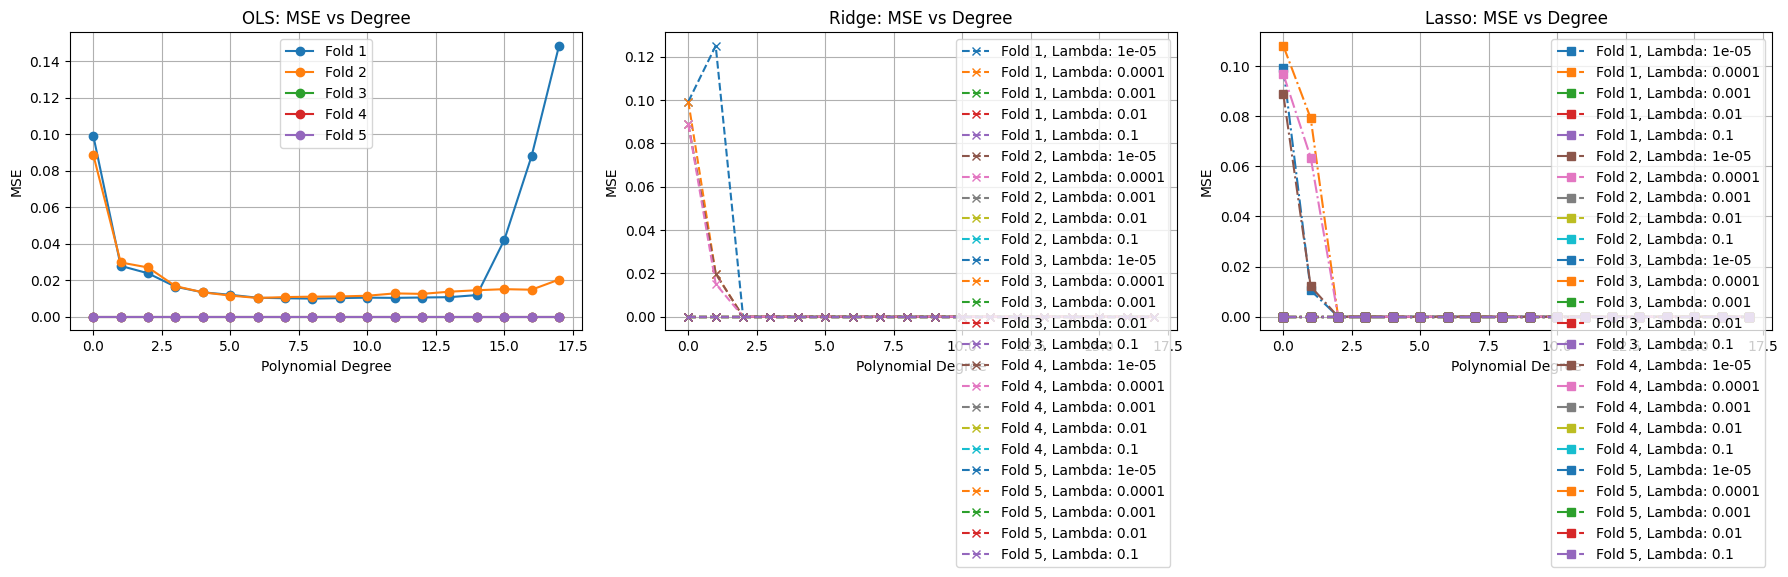

In [ ]:
plt.figure(figsize=(18, 5))

# Plotting OLS results
plt.subplot(1, 3, 1)
for fold in range(folds):
    plt.plot(degree, mse_ols[:, fold], label=f'Fold {fold + 1}', marker='o', linestyle='-')
plt.title('OLS: MSE vs Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.legend()
plt.grid()

# Plotting Ridge results
plt.subplot(1, 3, 2)
for fold in range(folds):
    for i, lam in enumerate(lambda_values):
        plt.plot(degree, mse_ridge[:, i, fold], label=f'Fold {fold + 1}, Lambda: {lam}', marker='x', linestyle='--')
plt.title('Ridge: MSE vs Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.legend()
plt.grid()

# Plotting Lasso results
plt.subplot(1, 3, 3)
for fold in range(folds):
    for i, lam in enumerate(lambda_values):
        plt.plot(degree, mse_lasso[:, i, fold], label=f'Fold {fold + 1}, Lambda: {lam}', marker='s', linestyle='-.')
plt.title('Lasso: MSE vs Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.legend()
plt.grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()